# Generating nodule images with Denoising Diffusion Model

## Training of DDPM on LIDC data.

Model is trained on nodule CT scans previously extracted from LIDC repository. Training images are of shape (1, 32, 32) and pixel values are scaled to the range [0, 1]

In [1]:
from torch.utils.data import DataLoader
from pathlib import Path
from tqdm import tqdm
from torchvision.utils import save_image, make_grid
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Importing modules
%load_ext autoreload
%autoreload 2

from DDPM_model import DDPM_model
from LIDC_Dataset import LIDC_Dataset

In [3]:
def train_DDPM(n_epoch, batch_size, n_T, device, n_feat, lrate, model_name):
    
    # General settings:
    n_classes = 2 # in the LIDC dataset there are only two classes: beningn and malignant
    save_model_structure = True # saving structure and weights
    save_weights_only = False # saving only weights
    ws_test = [0.5, 1.0, 1.5, 2.0] # strength of generative guidance

    # Path settings:
    plot_path = f"./plots/{model_name}/"
    model_path = "./saved_model/"
    Path(plot_path).mkdir(parents=True, exist_ok=True)
    Path(model_path).mkdir(parents=True, exist_ok=True)

    # Creating model instance:
    ddpm = DDPM_model(n_feat=n_feat, n_T=n_T, device="cuda")
    ddpm.to(device)

    # Preparing dataset, dataloader, optimizer:
    dataset = LIDC_Dataset("/home/dzban112/LIDC_repo/dataset", train_mode=True)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    optim = torch.optim.Adam(ddpm.parameters(), lr=lrate)

    for ep in range(n_epoch):
        print(f'epoch {ep}')
        ddpm.train()

        # linear lrate decay
        optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)

        pbar = tqdm(dataloader)
        loss_ema = None
        for x, c in pbar: # x is a batch of images, c is a corresponding context (label set)
            optim.zero_grad()
            x = x.to(device)
            c = c.to(device)
            loss = ddpm(x, c)
            loss.backward()
            if loss_ema is None: # Exponential moving average of loss is used to monitor loss across batches.
                loss_ema = loss.item()
            else:
                loss_ema = 0.95 * loss_ema + 0.05 * loss.item()
            pbar.set_description(f"loss: {loss_ema:.4f}")
            optim.step()
        
        if(ep%5 == 0 or ep == int(n_epoch-1)): 
            # for evaluation, save an image of currently generated samples (top 8 rows)
            # followed by real images (bottom 8 rows)
            ddpm.eval()
            with torch.no_grad():
                n_sample = 8*n_classes
                
                for w in ws_test:
                    x_gen, _, x_gen_store = ddpm.sample(n_sample, (1, 32, 32), device, guide_w=w)
                    # append some real images at bottom, order by class also
                    x_real = torch.Tensor(x_gen.shape).to(device)
                    for k in range(n_classes):
                        for j in range(int(n_sample/n_classes)):
                            try: 
                                idx = torch.squeeze((c == k).nonzero())[j]
                            except:
                                idx = 0
                            x_real[k+(j*n_classes)] = x[idx]

                    x_all = torch.cat([1-x_gen, 1-x_real])
                    grid = make_grid(x_all*-1 + 1, nrow=2)
                    save_image(grid, plot_path + f"image_ep{ep}_w{w}.png")
                    print('saved image at ' + plot_path + f"image_ep{ep}_w{w}.png")

        if save_model_structure and ep == int(n_epoch-1):
            torch.save(ddpm, model_path + f"{model_name}_{ep}.pth")
            print('saved model at ' + model_path + f"{model_name}_{ep}.pth")
        elif save_weights_only and ep == int(n_epoch-1):
            torch.save(ddpm.state_dict(), model_path + f"{model_name}_{ep}.pth")
            print('saved model at ' + model_path + f"{model_name}_{ep}.pth")

In [ ]:
train_DDPM(n_epoch=35, batch_size=32, n_T=1000, device="cuda", n_feat=256, lrate=1e-4, model_name="model_256F_1000T")

## Generating images with trained model

In [3]:
def plot_grid(x_gen, n_sample, c):
    assert n_sample%2==0, "n_sample should be odd!"
    plt.set_cmap('gray')
    fig, axes = plt.subplots(2, int(n_sample/2), figsize=(12, 5))
    k=0
    for i in range(axes.shape[0]):
        for j in range(n_sample//2):
            img = x_gen[k][0].cpu()
            axes[i][j].imshow(img)
            axes[i][j].set_title(f"Class: {c[k]}")
            k+=1
    fig.tight_layout()
    fig.subplots_adjust(top=0.92)
    fig.suptitle('Generated images', size=16)
    return fig


def plot_image(path2imgs, img_name, grid=True):
    plt.set_cmap('gray')         
    img = torch.load(f"{path2imgs}/{img_name}").cpu()[0]
    plt.imshow(img)
    plt.show()


def generate(n_sample, guide_w, path_to_model, test_gen=True, grid_name=None):
    device = torch.device("cuda")
    ddpm = torch.load(path_to_model)
    ddpm = ddpm.to(device)   
    ddpm.eval()
    
    with torch.no_grad():
        x_gen, c, x_gen_store = ddpm.sample(n_sample, (1, 32, 32), device, guide_w=guide_w)
    if test_gen:
        plot = plot_grid(x_gen, n_sample, c)
        figure = plot.get_figure()
        #figure.savefig(f"{grid_name}_guide_{guide_w}.png")
    else:
        return x_gen, c, x_gen_store 


## Trial generation


sampling timestep 1000


<Figure size 640x480 with 0 Axes>

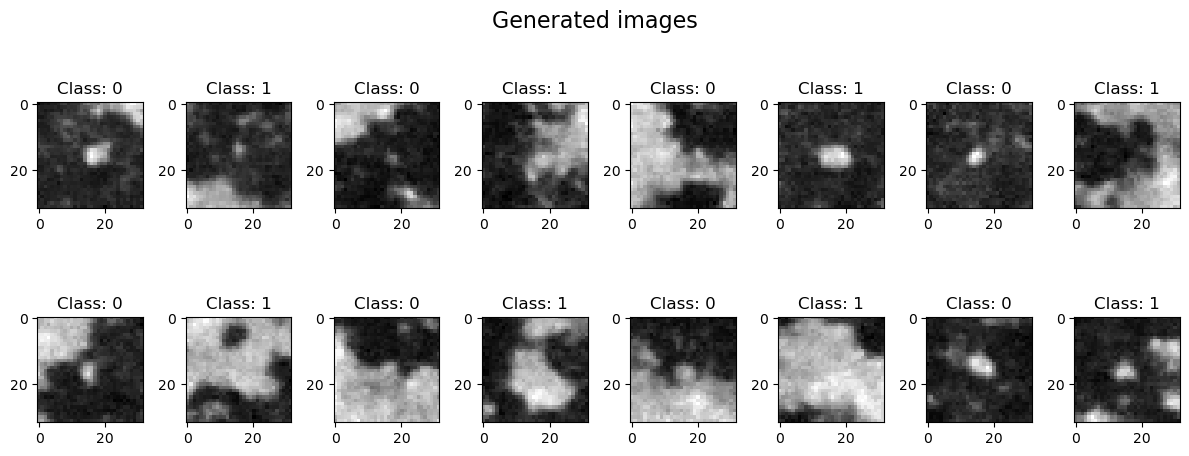

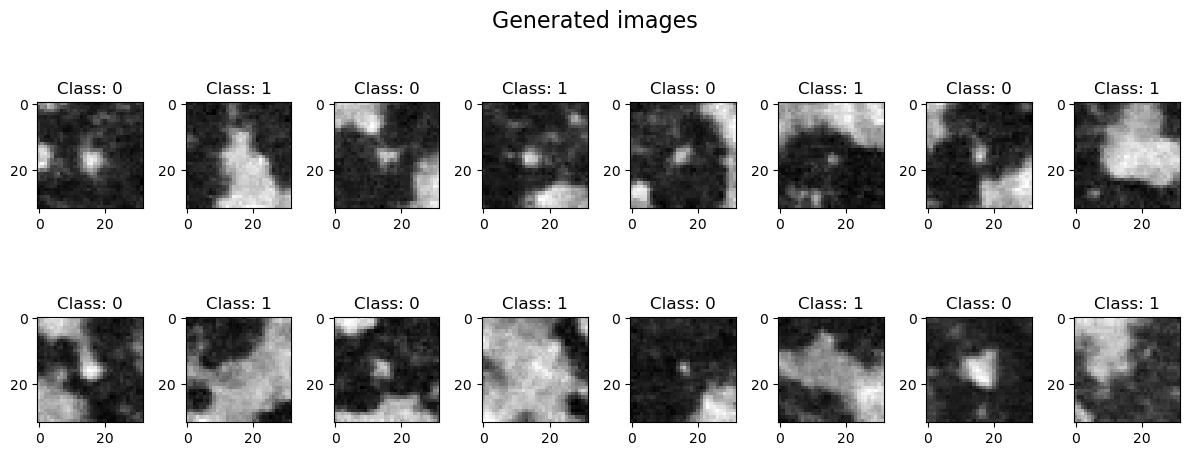

In [4]:
# Model 256 features in the latent space, n_T=1000:
for guide_w in [0.0, 0.2]:
    generate(n_sample=16, guide_w=guide_w, path_to_model="./saved_model/model_256F_1000T_34.pth", test_gen=True, grid_name="model_256F_1000T")

## Generation and saving a lot of images

Generation takes quite a lot of time, so it is better to send task to slurm  rather than generate in notebook. In repository there is prepared script: ```generate_script.py```.

In [ ]:
# ! sbatch wsad.slurm